# Composite systems and interface with QuTIP

B. McDonough

For further documentation of scqubits see https://scqubits.readthedocs.io/en/latest/.

Systems of interests for quantum computing involve mutual coupling between different subsystems consisting of qubits and oscillators. The eigenstates of these systems can then be used for computation. In order to achieve the transitions between these eigenstates to perform gates, it is necessary to drive different components of the circuit.

One common way to drive the circuit is to introduce a voltage to one of the nodes of the circuit. Through a proper choice of the waveform of the driving voltage, different dynamics can be achieved to perform logical operations on the eigenstates of the qubits.

The popular python package QuTiP can be used to simulate these time dynamics to study them. scQubits proves an easy and transparent interface to QuTiP through the `HilbertSpace` class. A tutorial on the usage of the HilbertSpace class can be found [here](https://github.com/scqubits/scqubits-examples/blob/master/examples/demo_hilbertspace.ipynb). 

## Composite Systems in scQubits
A system consisting of several coupled subsystems can be represented using a Hamiltonian of the form

$$ 
H' = \sum_{i}H_0^{(i)} + \sum_{ij}H_1^{(ij)}
$$

where $i,j$ both index over the subsystems. Here, $H_0^{(i)}$ is the "bare" Hamiltonian of the $i^\text{th}$ subsystem, only acting nontrivially on this subsystem. 

$H_1^{(ij)}$ is the Hamiltonian modeling the coupling of subsystem $i$ to subsystem $j$, and similarly only acts nontrivially on these two subsystems. Capacitive coupling between a qubit and a resonator, which is the standard way to couple qubits, results in a coupling Hamiltonian of the form $H_1^{(ij)} = g_{ij}\hat n_i (a_j + a^{\dagger}_j)$, where $\hat n_i$ is the charge operator for the $i^\text{th}$ qubit and $a_j, a_j^\dagger$ are the annihilation and creation operators respectively for the $j^\text{th}$ resonator. Driving is usually restricted to the dispersive regime, where $g$ is relatively small compared to the frequency difference $\Delta$ between the oscillator and the qubit.

scQubits models such a system by first diagonalizing each $H_0^{(i)}$ in the basis $| \mu_i \rangle$ most appropraite for each qubit. Tensor products of these eigenstates $| \mu_{\vec i}\rangle = |\mu_{i_1}\rangle_1 \otimes |\mu_{i_2}\rangle_2 \otimes ... \otimes |\mu_{i_n}\rangle_n$, known as the "bare" eigenstates, are used to write the Hamiltonian $H' =  \sum_{i}H_0^{(i)} + \sum_{ij}H_1^{(ij)}$ as a matrix by computing $\langle \mu_{\vec k} | H^{(ij)} | \mu_{\vec l} \rangle$ for each $i,j,k,l$. Lastly, these matrix elements are used to diagonalize $H'$, obtaining the "dressed" eigenstates of the coupled system and the corresponding energy levels.

## Driving Operators
The affect of a time-dependent voltage introduced at one or more of the nodes of the circuit can be taken into account through the addition of a term to the Hamiltonian:
$$
H = H' + \sum_i H_d^{(i)}
$$
As long as the voltage is connected only to a single node of the circuit, the drive term cannot further couple two subsystems. The term $H_d^{(i)}$ only acts nontrivially on the $i^\text{th}$ subsystem, and takes the form $H_d = \varepsilon(t)\hat n_i$, where $\hat n_i$ is the charge number operator for the $i^\text{th}$ subsystem.

## Example: Fluxonium coupled to a resonator

The Hamiltonian of a fluxonium qubit can be written as
$$
H_0 ^{(f)} = 4E_C \hat n_f^2 - E_J \cos(\hat\phi_f-\varphi_{ext})+\frac{1}{2}E_L\hat\phi_f^2 \ .
$$
The Hamiltonian of a resonator is 
$$
H_0^{(r)} = E_{osc}a^\dagger a \ ,
$$
where the units are chosen so that $\hbar = 1$, and the additional $\frac{\omega}{2}$ term is customarily dropped. For an on-chip resonator, the charge on the qubit naturally couples to the charge on the resonator, so the coupling Hamiltonian $H_1$ is proportional to $\hat n_{r}\hat n_{f}$. We define the resonator charge operator as $\hat n_r = n_{ZPF}(a+a^\dagger)$, and we can create a real proportionality constant $g$ so that $H_1 = gn_r(a+a^\dagger)$. The Hamiltonian modeling the interaction between these two systems can be written as
$$
H' = H_{0}^{(f)} + H_{0}^{(r)} + g\hat n_r(a+a^\dagger)
$$
scQubits is able to represent such a coupled system and diagonalize it for an appropriate choice of $g$. The process for doing so is shown below:

## Set up Hilbert space

Following the procedure described in the scQubits tutorial, we can represent this Hamiltonian $H'$ using a `HilbertSpace` object. This class is the main way to symbolically represent coupled systems in scQubits, and it also is one of the main points of exposure between the scQubits API and QuTiP.

In [ ]:
import scqubits as scq
import numpy as np
import qutip as qt
'''want to import everything in the beginning as opposed to sporadically throughout'''

In [1]:
'''could be nice to choose parameters from a recent paper. Not sure if that was done here or 
if these are just randmon numbers'''
qbt = scq.Fluxonium(
    EJ = 8.9,
    EC = 2.5,
    EL = 0.5,
    flux = 0.33,
    cutoff = 110,
    truncated_dim = 9,
    '''nice to initialize with convenient id strings'''
    id_str='fluxonium'
)

# same for the resonator
osc = scq.Oscillator(
    E_osc=4.0,
    truncated_dim=5,
    id_str='res'
)

hilbertspace = scq.HilbertSpace([qbt, osc])

g = .2
hilbertspace.add_interaction(
    g_strength = g,
    op1 = qbt.n_operator,
    op2 = osc.creation_operator,
    add_hc = True
)

'''below text is extraneous, which I cut'''

# Drive operators
The drive Hamiltonians $H_d^{(i)}$, as discussed, are proportional to the charge number operators $\hat n_i$. These operators are generally off-diagonal with respect to the energy eigenbasis. In order to simulate the evolution of the system with qutip, these operators first need to be expressed in the energy eigenbasis.

The `HilbertSpace` class provides many ways to amortize the cost of diagonalization so that the dressed eigenvectors do not need to be recomputed every time a new operators is needed. `HilbertSpace` supports a dictionary interface to look up these values directly. The `subsystem.truncated_dim` parameter is used to control the cuttoff of each of the subsystems in the energy eigenbasis. 

The basis transformation is performed in two steps. First, the operator is expressed in the natural basis, such as the charge basis for Transmons and other charge qubits. The matrix elements in this basis are often trivial to express, but they may also have a non-trivial overlap with many energy eigenstates, so it is not safe to truncate in this basis. Therefore, the first step is to convert the $\hat n$ operator into the bare energy eigenbasis, corresponding to the uncoupled Hamiltonian $H_0$ of the subsystem. HilbertSpace may choose a particular basis in which to express this Hamiltonian in different situations, so it is important to query these eigenvectors from the HilbertSpace object. The `identity_wrap` function will perform two functions. First, it will compute the matrix elements in the desired eigenbasis, and secondly, it will properly tensor $\hat n$ with identity operators for the other subsystems so that the resultant operator has full rank.

The representation of $\hat n$ in the bare energy eigenbasis can be safely truncated to a level specified by a cutoff parameter in the constructor of the object, since the anharmonicity of the qubit will allow high-lying energy levels to be safely neglected. This offers a speedup for the second part of the process, which is to compute the matrix elements in the dressed eigenbasis, which accounts for the contribution of the coupling terms to the energy eigenstates.

In [2]:
#populate the dictionaries with the choice of eigenstates
hilbertspace.generate_lookup()

In [3]:

#convert an operator from the bare eigenbasis to the dressed eigenbasis
def bare_to_dressed(operator, hilbertspace):
    # why the comma?
    evecs, = hilbertspace["evecs"]
    return operator.transform(evecs)

#get the bare productstate by subsystem
def lookup_productstate(*states):
    states_by_index = sorted([(hilbertspace.get_subsys_index(sys), state) for (sys, state) in states])
    return hilbertspace.bare_productstate([state for sys,state in states_by_index])

def basis_change(operator, subsystem, hilbertspace, dressed_eigenbasis = True):
    """This method can be used to express a subsystem operator in the dressed energy eigenbasis
    of the full hilbertspace, especially useful for simulations in QuTiP.

    Args:
        operator (Qobj): A subsystem operator with dimension cutoff x cutoff
        subsystem (Qubit or Resonator): The subsystem acted on by the operator
        hilbertspace (HilbertSpace): The Hilbert space representing the composite system

    Returns:
        (Qobj): An operator with the same dimension as the HilbertSpace
    """

    #Get bare eigenvectors of subsystem stored in hilbertspace
    """anomalous behavior is a strong statement! I would kill that comment"""
    hilbertspace.bare_eigenstates(subsystem) #deal with anomalous behavior
    bare_evecs, = hilbertspace.bare_eigenstates(subsystem)
    #Express operator in bare eigenbasis and tensor with appropriate identities
    op_id_wrap = scq.identity_wrap(operator, subsystem, hilbertspace.subsys_list, evecs = bare_evecs)
    #Get full dressed eigenbasis
    evecs, = hilbertspace["evecs"]
    if dressed_eigenbasis:
        evecs, = hilbertspace["evecs"]
        return bare_to_dressed(op_id_wrap, hilbertspace)
    else:
        #Transform wrapped operator into dressed eiegenbasis
        return op_id_wrap

### Compute charge operators
This method can now be used to express both charge operators acting on the full system in the dressed energy eigenbasis:

In [4]:
#resonator charge operator
'''again I would avoid using n_r, go with phi_r instead or something'''
n_r = basis_change(osc.annihilation_operator()+osc.creation_operator(), osc, hilbertspace)
#qubit charge operator
n_qbt = basis_change(qbt.n_operator(), qbt, hilbertspace)

## Driving Simulation in QuTIP
Now that the operators are obtained in the new energy eigenbasis, qutip's `sesolve` or `mesolve` functionality can be used to simulate the time dynamics associated with driving the system. In the case of the Fluxonium, the $\hat n$ operator is seen to act like a $\sigma_x$ operator on the first two energy eigenstates, transitioning between them. If the frequency of the drive $\omega_d$ is chosen to be the resonant frequency of the qubit, then the $z$ rotation due to the Hamiltonian is suppressed, and a Rabi transition between the first and second energy levels can be observed.

The drive can either be applied to the qubit directly or to the resonator. Since the frequency of the resonator is detuned from the frequency of the qubit, the qubit may be driven directly without creating photons in the resonator, and virtual excitations can be created in the resonator to drive the qubit.

In [6]:
'''this is epsilon in the above discussion?'''
Omega = 2*np.pi*.01 #Drive strength in GHz
#0-1 transition frequency of the qubit
wd, = hilbertspace.energy_by_bare_index((1,0)) - hilbertspace.energy_by_bare_index((0,0))

#time-dependent drive
def drive_coeff(t, args):
    omega_d = args['omega_d']
    return Omega*np.cos(wd*t)

#Hamiltonian is the interaction Hamiltonian plus the drive Hamiltonian 
'''You can observe that bare_to_dressed(hilbertspace.hamiltonian(), hilbertspace) is 
just a diagonal operator of the dressed eigenvalues. Could be nicer to construct that 
matrix with just np.diag(evals) or whatever instead of the complicated below. Reserve that
for the drive operators which actually need it!'''
H_qbt_drive = [bare_to_dressed(hilbertspace.hamiltonian(), hilbertspace),[n_qbt, drive_coeff]]

In [7]:
state = lookup_productstate((qbt, 0), (osc,0))
tlist = np.linspace(0, 1000, 1000)
result = qt.sesolve(H_qbt_drive, state, tlist, e_ops = [state*state.dag()], args = {"omega_d": wd})

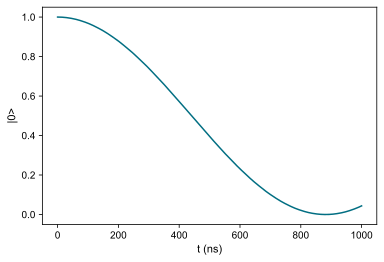

In [9]:
from matplotlib import pyplot as plt
plt.plot(tlist, result.expect[0])
plt.xlabel("t (ns)")
plt.ylabel("|0>")
# nice to have the following below
plt.show()

### Driving through the resonator

In [10]:
Omega = 2*np.pi*.01 #Drive strength in GHz
#0-1 transition frequency of the qubit
wd, = hilbertspace.energy_by_bare_index((1,0)) - hilbertspace.energy_by_bare_index((0,0))

#time-dependent drive
def drive_coeff(t, args):
    omega_d = args['omega_d']
    return Omega*np.cos(wd*t)

#Hamiltonian is the interaction Hamiltonian plus the drive Hamiltonian 
H_osc_drive = [bare_to_dressed(hilbertspace.hamiltonian(), hilbertspace),[n_r, drive_coeff]]

In [11]:
state = lookup_productstate((qbt, 0), (osc,0))
tlist = np.linspace(0, 5000, 5000)
result = qt.sesolve(H_osc_drive, state, tlist, e_ops = [state*state.dag()], args = {"omega_d": wd})

Text(0, 0.5, '|0>')

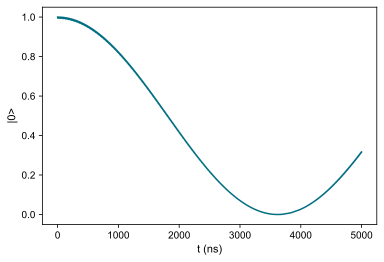

In [12]:
from matplotlib import pyplot as plt
plt.plot(tlist, result.expect[0])
plt.xlabel("t (ns)")
plt.ylabel("|0>")